## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
model_path = os.path.join('..', 'models')

model_name = 'RandomForestClassifier'


## 1 - Load and prepare the dataset

In [2]:
# Load the saved data, otherwise load the seperate training, validation, test and final evaluation datasets
if os.path.exists(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet')):
    procd_data = pd.read_parquet(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet'))
else:
    procd_train = pd.read_parquet(os.path.join(processed_data_path, 'procd_train.parquet'))
    procd_val = pd.read_parquet(os.path.join(processed_data_path, 'procd_val.parquet'))
    procd_test = pd.read_parquet(os.path.join(processed_data_path, 'procd_test.parquet'))
    procd_final_eval = pd.read_parquet(os.path.join(processed_data_path, 'procd_final_eval.parquet'))

    # Concatenate datasets
    procd_data = pd.concat([procd_train, procd_val, procd_test, procd_final_eval])
    procd_data.reset_index(drop=True, inplace=True)

## 2 - Extract text features for each group

In [3]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model
from pyLDAvis import PreparedData

#pyLDAvis.enable_notebook()

### 2.1 - Aggregate text data by group

In [4]:
# Drop the rows with missing 'DIAG1_CAT' and combine the text features,
# if procd_train, procd_val, procd_test and procd_final_eval are loaded
if ('procd_train' in globals()) & ('procd_final_eval' in globals()):
    # Drop the rows with missing 'DIAG1_CAT'
    procd_data = procd_data.dropna(subset=['DIAG1_CAT'])

    # Combine the text features
    procd_data['CombinedText'] = procd_data.apply(lambda x: build_features.combine_textual(x, procd_data.columns.tolist()), axis=1)

procd_data.CombinedText.head()

0    55_year_old Middle_Aged Unintentional injury/p...
1    66_year_old Senior New problem Cough Symptoms ...
2    1_year_old Child_or_Teenager Female New proble...
3    21_year_old Adult Female Tobacco_User New prob...
4    84_year_old Senior Female Chronic problem, rou...
Name: CombinedText, dtype: object

### 2.2 - Preprocess text data

In [5]:
import spacy
import re

In [6]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(row):
    row = re.sub(r'(\d+),(\d+)', r'\1\2', row)
    row = re.sub(r'(\d+)-(\d+)', r'\1_\2', row)
    doc = nlp(row)
    processed_text = ' '.join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct)
    row = re.sub(r'(\d+)_(\d+)', r'\1-\2', row)
    return processed_text

In [7]:
# Process the combined text,
# if procd_train, procd_val, procd_test and procd_final_eval are loaded
if ('procd_train' in globals()) & ('procd_final_eval' in globals()):
    procd_data['ProcessedText'] = procd_data['CombinedText'].apply(preprocess_text)
    procd_data.to_parquet(os.path.join(processed_data_path, 'procd_data_w_combined_text.parquet'))

procd_data.ProcessedText.head()

0    55_year_old middle_age unintentional injury po...
1    66_year_old senior new problem cough symptoms ...
2    1_year_old child_or_teenager female new proble...
3    21_year_old adult female tobacco_user new prob...
4    84_year_old senior female chronic problem rout...
Name: ProcessedText, dtype: object

### 2.3 - Calculate term frequencies

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Method 1
# Calculate the TF-IDF for each group,
# taking the ProcessedText of each group as the documents,
# and the ProcessedText of the entire dataset as the corpus

#group_text = train_df.groupby('DIAG1_CAT')['ProcessedText'].apply(lambda row: ' '.join(row)).reset_index()

#vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=1000, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(group_text['ProcessedText'])

#print(tfidf_matrix)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df

In [10]:
# Method 2
# Calculate the TF-IDF of each row within each group
# Calculate the average TF-IDF for each group

vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=None, min_df=5, max_df=0.5)
tfidf_matrix = vectorizer.fit_transform(procd_data['ProcessedText'])

# Calculate the average TF-IDF for each cluster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
group_tfidf = pd.concat([procd_data['DIAG1_CAT'], tfidf_df], axis=1).groupby('DIAG1_CAT').mean()

group_tfidf.shape

(17, 965)

In [11]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

## 3 - Generate word clouds for each group

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

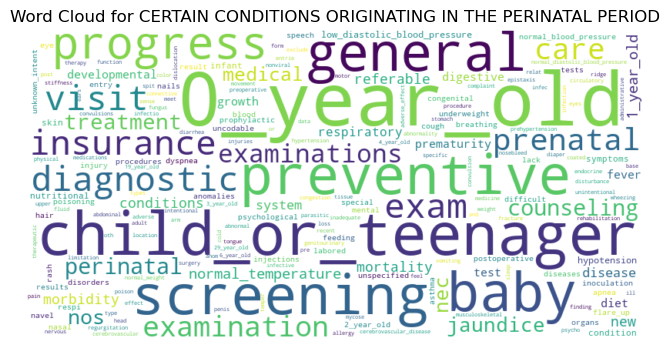

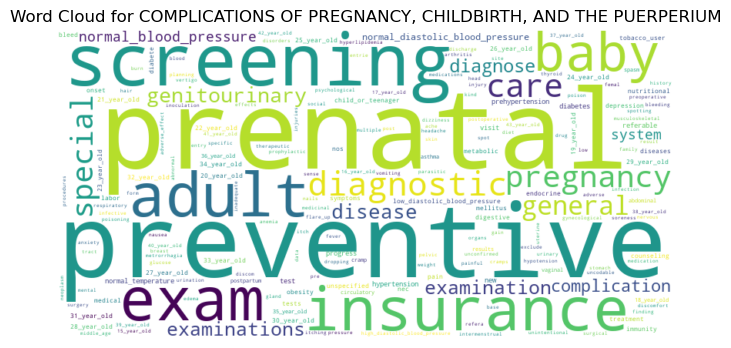

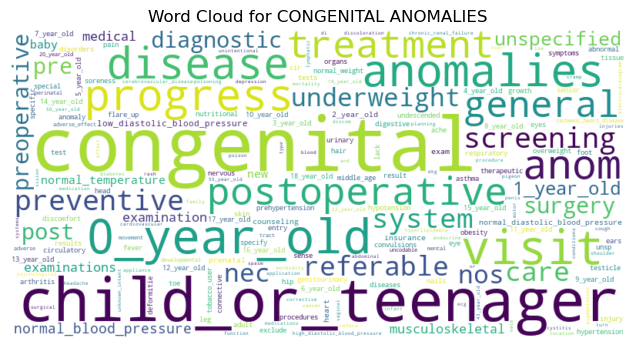

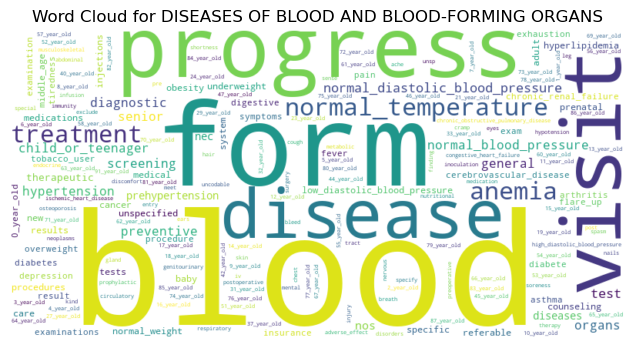

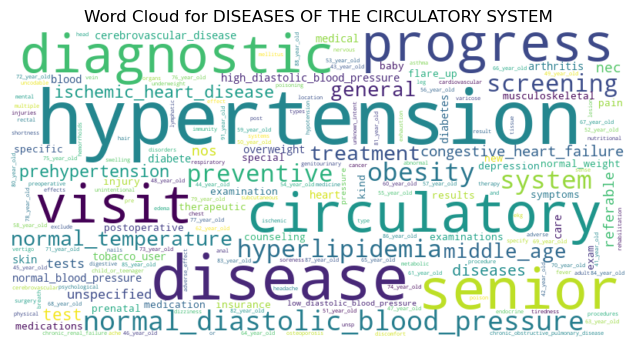

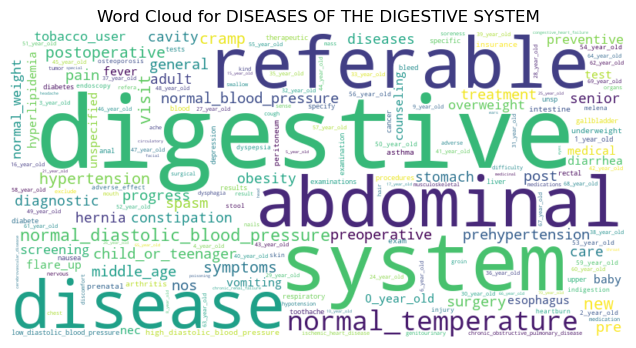

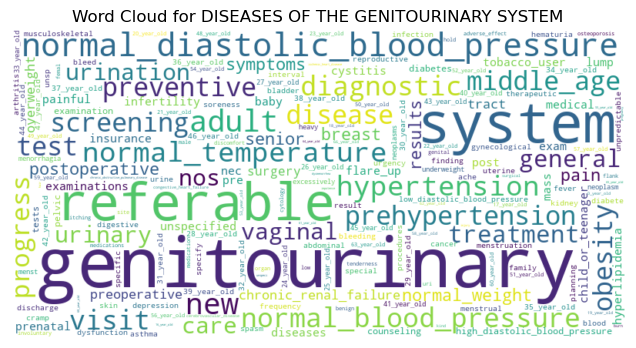

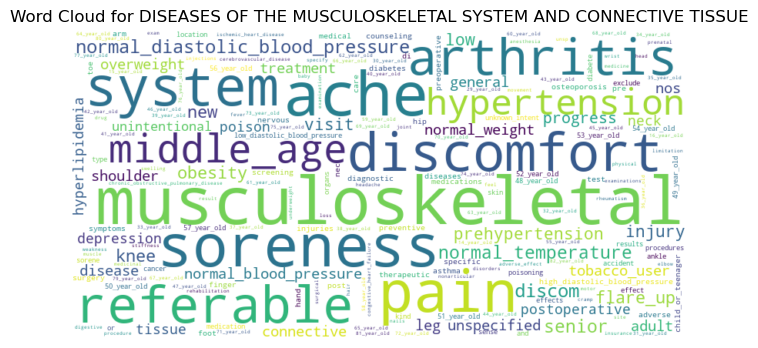

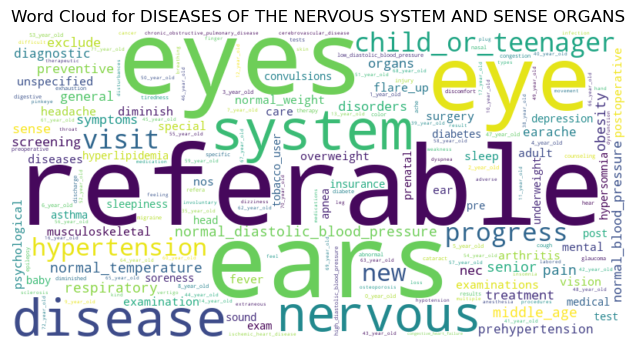

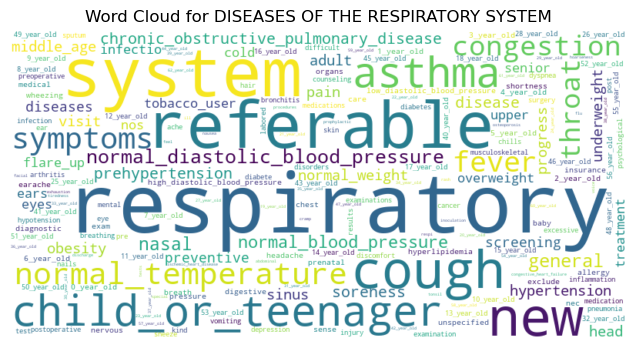

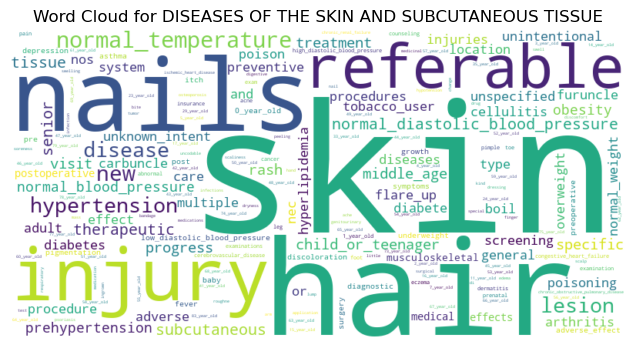

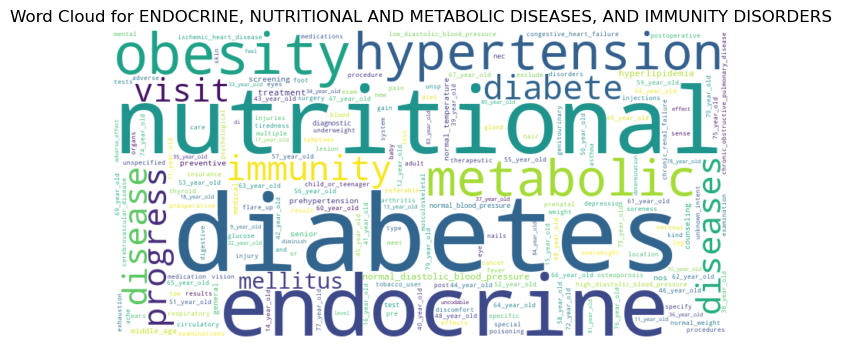

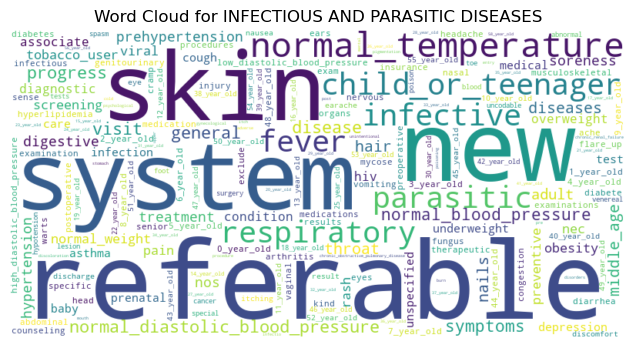

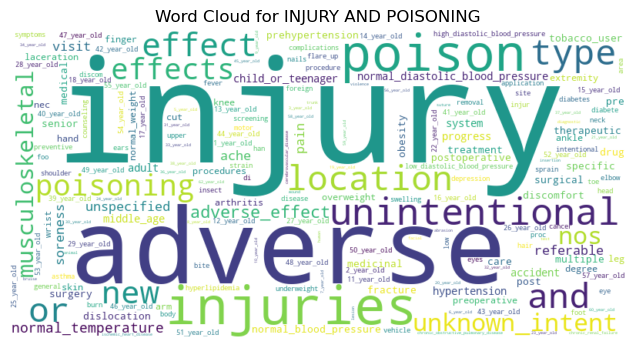

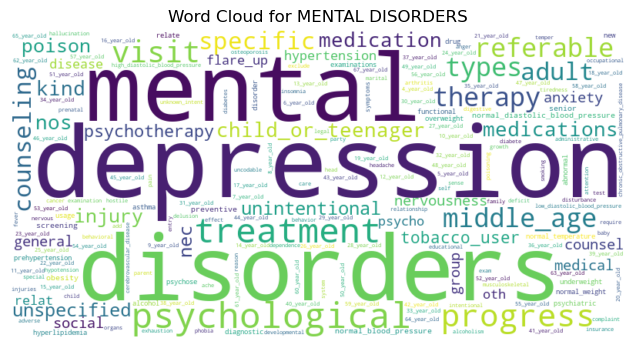

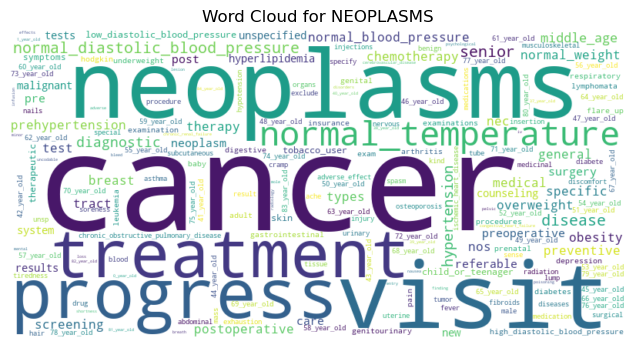

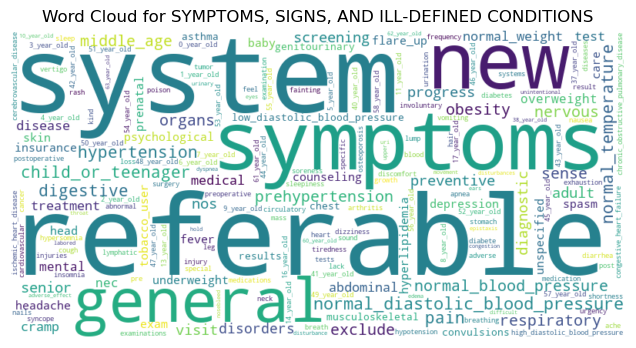

In [13]:
# Plot the word cloud for each 'DIAG1_CAT' based on the average TF-IDF
for category in group_tfidf.index:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(group_tfidf.loc[category])
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

## 4 - Medical pathways

### 4.1 - Load and concatenate the datasets

In [14]:
# 'services' features
binary_services = [
    'BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE','CBC',
    'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG',
    'URINE', 'HTTAKE', 'WTTAKE', 'TEMPTAKE', 'BLODPRES', 'CAM', 'DME', 'HOMEHLTH', 'HOSPICE', 'PT', 'RADTHER', 'SPOCTHER',
    'PSYCHOTH', 'OTHMNTL', 'EXCISION', 'WOUND', 'CATSCAN', 'PREGTEST', 'FOOT', 'RETINAL', 'HIVTEST', 'CAST', 'SPLINT'
]
print(f'Binary Services: {binary_services}')

nominal_services = ['PROC1', 'PROC2', 'PROC3', 'PROC4', 'PROC5', 'PROC6', 'PROC7', 'PROC8', 'PROC9']
print(f'Nominal Services: {nominal_services}')
print()

# 'medicationsAndImmunizations' features
quantitative_med = ['NUMNEW', 'NUMCONT']
print(f'Quantitative Medications: {quantitative_med}')

binary_med = [
    'MED1', 'MED2', 'MED3', 'MED4', 'MED5', 'MED6', 'MED7', 'MED8',
    'NCMED1', 'NCMED2', 'NCMED3', 'NCMED4', 'NCMED5', 'NCMED6', 'NCMED7', 'NCMED8'
]
print(f'Binary Medications: {binary_med}')

nominal_med = ['PHYS', 'PHYSASST', 'NPNMW', 'RNLPN', 'OTHPROV', 'MHP']
print(f'Nominal Medications: {nominal_med}')
print()

# 'providersSeen' features
binary_ps = ['PHYS', 'PHYSASST', 'NPNMW', 'RNLPN', 'OTHPROV', 'MHP']
print(f'Binary Providers Seen: {binary_ps}')
print()

# 'visitDisposition' features
binary_vd = ['REFOTHMD', 'RETAPPT', 'OTHDISP', 'ERADMHOS']
print(f'Binary Visit Disposition: {binary_vd}')
print()

# 'DIAG' features
nominal_diag = ['DIAG1', 'DIAG1_CAT1', 'DIAG1_CAT2']
print(f'Nominal Diagnosis: {nominal_diag}')
text_diag = 'DIAG1_TEXT'
print(f'Text Diagnosis: {text_diag}')

Binary Services: ['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE', 'TEMPTAKE', 'BLODPRES', 'CAM', 'DME', 'HOMEHLTH', 'HOSPICE', 'PT', 'RADTHER', 'SPOCTHER', 'PSYCHOTH', 'OTHMNTL', 'EXCISION', 'WOUND', 'CATSCAN', 'PREGTEST', 'FOOT', 'RETINAL', 'HIVTEST', 'CAST', 'SPLINT']
Nominal Services: ['PROC1', 'PROC2', 'PROC3', 'PROC4', 'PROC5', 'PROC6', 'PROC7', 'PROC8', 'PROC9']

Quantitative Medications: ['NUMNEW', 'NUMCONT']
Binary Medications: ['MED1', 'MED2', 'MED3', 'MED4', 'MED5', 'MED6', 'MED7', 'MED8', 'NCMED1', 'NCMED2', 'NCMED3', 'NCMED4', 'NCMED5', 'NCMED6', 'NCMED7', 'NCMED8']
Nominal Medications: ['PHYS', 'PHYSASST', 'NPNMW', 'RNLPN', 'OTHPROV', 'MHP']

Binary Providers Seen: ['PHYS', 'PHYSASST', 'NPNMW', 'RNLPN', 'OTHPROV', 'MHP']

Binary Visit Disposition: ['REFOTHMD', 

### 4.1 - Possibilities of sevices arranged for each 'DIAG1_CAT1' group

In [16]:
# Check the count of missing values for each feature in 'binary_services'
procd_data[binary_services].isnull().sum()

KeyError: "None of [Index(['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO',\n       'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA',\n       'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ',\n       'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE', 'TEMPTAKE',\n       'BLODPRES', 'CAM', 'DME', 'HOMEHLTH', 'HOSPICE', 'PT', 'RADTHER',\n       'SPOCTHER', 'PSYCHOTH', 'OTHMNTL', 'EXCISION', 'WOUND', 'CATSCAN',\n       'PREGTEST', 'FOOT', 'RETINAL', 'HIVTEST', 'CAST', 'SPLINT'],\n      dtype='object')] are in the [columns]"